<a href="https://colab.research.google.com/github/escaduto/BuildingExtraction/blob/master/%5B2%5D_BuildingDamage_STA221_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Damage Assessment - XGBoost
This notebook use XGBoost to classify building damage based on a subset of 4 million pixels from the extracted NAIP images (see notebook: _[1]_BuildingDamage_STA221_feature_ML_ for extraction).

## Set up and Load Data

### Google Drive & Path

In [ ]:
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/STA221_FinalProj"
%ls "./Data/FireDataset/train"

### Prepare Packages

In [ ]:
!pip install rasterio

     |████████████████████████████████| 18.2MB 28.8MB/s 


In [ ]:
!pip install geopandas

     |████████████████████████████████| 931kB 5.8MB/s 
     |████████████████████████████████| 10.9MB 177kB/s 
     |████████████████████████████████| 14.7MB 210kB/s 


In [ ]:
!pip install imagecodecs
!pip install tifffile
#need to upgrade to read compressed tiff in Colab
!pip install --upgrade scikit-image

     |████████████████████████████████| 17.9MB 171kB/s 
     |████████████████████████████████| 12.4MB 250kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


## Load packages and data

In [ ]:
from skimage import io
import imagecodecs
import os, fnmatch,tifffile
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import model_selection
import matplotlib.image as mpimg



In [ ]:
# retrieve file path + names based on extension
def lstFiles(rootPath, ext):
    file_list = []
    root = rootPath
    for path, subdirs, files in os.walk(root):
        for names in files: 
            if names.endswith(ext) and not names.startswith("._"):
                file_list.append(path  +"/" + names)
    return(file_list)


# get merged all test/train dataset
merged_path = "./Data/FireDataset/merged_shp"
merged_files = lstFiles(merged_path, '.shp')
gdf = gpd.read_file(merged_files[0])
santaRosa = gdf.query("location_n == 'santa-rosa-wildfire'")
ID_list=santaRosa.ID.unique()

In [ ]:
#get files by match pattern
def find(pattern, path):
    '''
    #find names of files that match the pattern
    args:
    pattern: string to be matched
    path: path of files
    '''
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

### Get Data for Training
Use a subset of 4 million pixels * 43 features for training due to the data size limitations from Google Colab

In [ ]:
folder='./NAIP_img_new/'
#the number of features (including ground truth layer)
n_feature=44
data=np.empty(shape=(0,n_feature),dtype='float')
#counter=0
#combine all pre post images together
#for index in ID_list:
#test on a subset
for index in ID_list[:10]:
    #files=find('*'+index+'*.tif', folder) # data not returned in desired order for each index
    #pre
    img=io.imread(folder+'pre_'+index+'.tif')
    gt=io.imread(folder+'pre_'+index+'gt.tif')
    img=np.concatenate((img,gt[:,:,None]),axis=2)
    img=np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
    data=np.concatenate((data,img),axis=0)
    #post
    img=io.imread(folder+'post_'+index+'.tif')
    gt=io.imread(folder+'post_'+index+'gt.tif')
    img=np.concatenate((img,gt[:,:,None]),axis=2)
    img=np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
    data=np.concatenate((data,img),axis=0)
    #counter+=1
    #if counter%50==0:
        #print(index+'concatenated!')



## XGBoost

### Tune XGBoost

In [ ]:
features=['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'R_contrast', 'N_contrast', 'R_corr', 'G_corr', 'B_corr', 'N_corr', 'R_var', 'N_var', 'R_idm', 'G_idm', 'B_idm', 'N_idm', 'R_diss', 'N_diss', 'R_shade', 'G_shade', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha', 'KMeans', 'KMeans_Seg', 'SNIC', 'LVQ']

In [ ]:
features.append('y')
len(features)

44

In [ ]:
data=pd.DataFrame(data,columns=features)
X=data.iloc[:,:-1]
y=data['y']
#group y from 5 classes to 3 classes: 0: non building 1: undestroyed and 2: destroyed (remove minor and major imacts due to the limited samples)
y[y>=2]=2
y=y.astype('int')

In [ ]:
#split training and testing sets
train_X, val_X, train_y, val_y = model_selection.train_test_split(X, y,test_size=0.5,shuffle=True, random_state=23)

### Gridsearch

In [ ]:
#the data is too large and time consuming to tune with gridsearch due to the RAM size of Colab (~4 million pixels), randomly use 10% to tune the model
train_X, _, train_y, _ = model_selection.train_test_split(train_X, train_y,test_size=0.9,shuffle=True, random_state=23) 

In [ ]:
#seperate the tuning process to save time
param_grid = { 
    'n_estimators': [10,100,500],
    'learning_rate':[0.01,0.05,0.1,1,10],
    'max_depth' : [5,10,20],
    'min_child_weight': [0.5,1],
    'gamma':[0,0.5,1],
    'alpha':[0,0.5,1],
    'subsample': [1,3],
    'colsample_bytree': [0.5,1],
    'eta':[0.5,1],
    
}

First, tune n_estimators and learning_rate

In [ ]:
param_grid = { 
    'n_estimators': [10,100,500],
    'learning_rate':[0.01,0.05,0.1,1,10],
}

searchCV = model_selection.GridSearchCV(estimator=xgb.XGBClassifier(tree_method = "gpu_hist"), cv=5,
                        param_grid=param_grid,
                        #enable train score (however, this can be time-consuming)
                        n_jobs=-1,return_train_score=False)

#train,eval split
#split_value=int(0.5*len(train_X))
#split training and testing sets
tr_X, v_X, tr_y, v_y = model_selection.train_test_split(train_X, train_y,test_size=0.2,shuffle=True, random_state=23)
searchCV.fit(tr_X, tr_y,eval_set=[(v_X, v_y)],early_stopping_rounds=10,verbose=False)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 1, 10],
                         'n_estimators': [10, 100,

In [ ]:
#return the best n_neighbors
CV_result=pd.DataFrame(searchCV.cv_results_)
print('The best performing parameter:',searchCV.best_params_) 

The best performing parameter: {'learning_rate': 1, 'n_estimators': 500}


Then, tune depth and child weight

In [ ]:
param_grid = { 
    'max_depth' : [5,10,20],
    'min_child_weight': [0.5,1],
}
searchCV = model_selection.GridSearchCV(estimator=xgb.XGBClassifier(tree_method = "gpu_hist",learning_rate=1,n_estimators=500), cv=5,
                        param_grid=param_grid,
                        #enable train score (however, this can be time-consuming)
                        n_jobs=-1,return_train_score=False)

#train,eval split
#split_value=int(0.5*len(train_X))
#split training and testing sets
#tr_X, v_X, tr_y, v_y = model_selection.train_test_split(train_X, train_y,test_size=0.2,shuffle=True, random_state=23)
searchCV.fit(tr_X, tr_y,eval_set=[(v_X, v_y)],early_stopping_rounds=10,verbose=False)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=500, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'min_child_weight': [0.5, 1]},
             

In [ ]:
print('The best performing parameter:',searchCV.best_params_) 

The best performing parameter: {'max_depth': 10, 'min_child_weight': 0.5}


tune the regularization terms


In [ ]:
param_grid = { 
    'gamma':[0,0.5,1],
    'alpha':[0,0.5,1]
}
searchCV = model_selection.GridSearchCV(estimator=xgb.XGBClassifier(tree_method = "gpu_hist",learning_rate=1,n_estimators=500,max_depth=10,min_child_weight=0.5), cv=5,
                        param_grid=param_grid,
                        #enable train score (however, this can be time-consuming)
                        n_jobs=-1,return_train_score=False)

#train,eval split
#split_value=int(0.5*len(train_X))
#split training and testing sets
#tr_X, v_X, tr_y, v_y = model_selection.train_test_split(train_X, train_y,test_size=0.2,shuffle=True, random_state=23)
searchCV.fit(tr_X, tr_y,eval_set=[(v_X, v_y)],early_stopping_rounds=10,verbose=False)
print('The best performing parameter:',searchCV.best_params_) 

The best performing parameter: {'alpha': 0, 'gamma': 0}


Next, tune subsample, eta, and coksample by tree

In [ ]:
param_grid = { 
    'subsample': [1,3],
    'colsample_bytree': [0.5,1],
    'eta':[0.5,1]  
}
searchCV = model_selection.GridSearchCV(estimator=xgb.XGBClassifier(tree_method = "gpu_hist",learning_rate=1,n_estimators=500,max_depth=10,min_child_weight=0.5,alpha=0,gamma=0), cv=5,
                        param_grid=param_grid,
                        #enable train score (however, this can be time-consuming)
                        n_jobs=-1,return_train_score=False)

#train,eval split
#split_value=int(0.5*len(train_X))
#split training and testing sets
#tr_X, v_X, tr_y, v_y = model_selection.train_test_split(train_X, train_y,test_size=0.2,shuffle=True, random_state=23)
searchCV.fit(tr_X, tr_y,eval_set=[(v_X, v_y)],early_stopping_rounds=10,verbose=False)
print('The best performing parameter:',searchCV.best_params_) 

The best performing parameter: {'colsample_bytree': 1, 'eta': 0.5, 'subsample': 1}


### Fit the Model

In [ ]:
#split training and testing sets
train_X, val_X, train_y, val_y = model_selection.train_test_split(X, y,test_size=0.5,shuffle=True, random_state=23)

In [ ]:
#gbc=xgb.XGBClassifier(n_estimators=500,learning_rate=1,tree_method = "gpu_hist")
gbc=xgb.XGBClassifier(tree_method = "gpu_hist",n_estimators=500,learning_rate=1,max_depth=10,min_child_weight=0.5,gamma=0,alpha=0,subsample=1,colsample_bytree=1,eta=0.5)
#gbc.fit(train_X,train_y)

#fit on all training data
gbc.fit(X,y)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.5, gamma=0,
              learning_rate=1, max_delta_step=0, max_depth=10,
              min_child_weight=0.5, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

## Model Accuracy and Evaluation

### Accuracy

In [ ]:
from sklearn import metrics

In [ ]:
# get some test data
folder='./NAIP_img_new/'
#the number of features
n_feature=44
data_test=np.empty(shape=(0,n_feature),dtype='float')
shapes=[]
#counter=0
#combine all pre post images together
#for index in ID_list:
#test on a subset
for index in ID_list[10:15]:
    #files=find('*'+index+'*.tif', folder) # data not returned in desired order for each index
    #pre
    img=io.imread(folder+'pre_'+index+'.tif')
    gt=io.imread(folder+'pre_'+index+'gt.tif')
    img=np.concatenate((img,gt[:,:,None]),axis=2)
    shapes.append(img.shape)
    img=np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
    data_test=np.concatenate((data_test,img),axis=0)
    #post
    img=io.imread(folder+'post_'+index+'.tif')
    gt=io.imread(folder+'post_'+index+'gt.tif')
    img=np.concatenate((img,gt[:,:,None]),axis=2)
    shapes.append(img.shape)
    img=np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
    data_test=np.concatenate((data_test,img),axis=0)
    #if counter%50==0:
        #print(index+'concatenated!')

In [ ]:
data_test=pd.DataFrame(data_test,columns=features)
X_te=data_test.iloc[:,:-1]

In [ ]:
y_te=data_test['y']
#group y from 5 classes to 3 classes: 0: non building 1: undestroyed and 2: destroyed (remove minor and major imacts due to the limited samples)
y_te[y_te>=2]=2
y_te=y_te.astype('int')

In [ ]:
#predict
#pred_y=gbc.predict(val_X)
#print('The accuracy and weighted f1 score for xgboost with best parameters are: ',metrics.accuracy_score(val_y,pred_y),' and ',metrics.f1_score(val_y,pred_y,average='weighted'))
#predict on the test set
pred_y=gbc.predict(X_te)
print('The accuracy and weighted f1 score for xgboost with best parameters are: ',metrics.accuracy_score(y_te,pred_y),' and ',metrics.f1_score(y_te,pred_y,average='weighted'))

The accuracy and weighted f1 score for xgboost with best parameters are:  0.9085204450668678  and  0.8848609580119121


In [ ]:
print('The cohen Kappa is: ',metrics.cohen_kappa_score(y_te,pred_y),' and ',metrics.balanced_accuracy_score(y_te,pred_y))

The cohen Kappa is:  0.18875664451922114  and  0.4061697233526886


In [ ]:
cm=metrics.confusion_matrix(y_te, pred_y, labels=[0,1,2])
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[931328  12475   1417]
 [ 74612  12606    243]
 [  6311     50    622]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


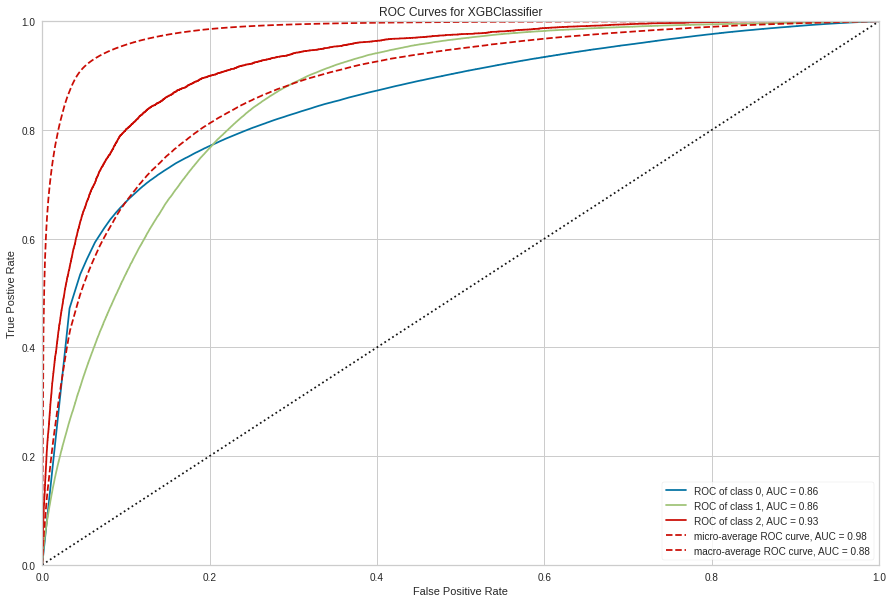

In [ ]:
from yellowbrick.classifier import ROCAUC
classes=[0,1,2]
rocauc = ROCAUC(gbc, size=(1080, 720), classes=classes)

rocauc.score(X_te, y_te)  
r = rocauc.poof()

### Prediction and Visualization

In [ ]:
def pred_visual(folder,index,state,features):
    '''
    This function takes one image, calculate the testing score on the image and visualize predictions
    folder: the folder (relative) to access the image
    index: string, image id: 00000XXX
    state: string, pre or post
    features: list of string, names of features
    '''
    img=io.imread(folder+state+'_'+index+'.tif')
    gt=io.imread(folder+state+'_'+index+'gt.tif')
    gt[gt>=2]=2
    shapes=img.shape
    #add ground truth as the last band
    img_data=np.concatenate((img,gt[:,:,None]),axis=2)
    img_data=np.reshape(img_data,(shapes[0]*shapes[1],(shapes[2]+1)))

    #organize dataframe
    img_data=pd.DataFrame(img_data,columns=features)
    X_te=img_data.iloc[:,:-1]
    y_te=img_data['y']
    #group y from 5 classes to 3 classes: 0: non building 1: undestroyed and 2: destroyed (remove minor and major imacts due to the limited samples)
    y_te[y_te>=2]=2
    y_te=y_te.astype('int')
    pred_y=gbc.predict(X_te)
    print('The accuracy and Kappa for this image are: ',metrics.accuracy_score(y_te,pred_y),' and ',metrics.cohen_kappa_score(y_te,pred_y))
    pred_image=np.reshape(pred_y,(shapes[0],shapes[1]))

    #show images
    _, axs = plt.subplots(1, 3, figsize=(11, 12))
    axs = axs.flatten()
    #for img, ax in zip([np.uint8(img[:,:,:3]),gt,pred_image], axs):
    for img, ax in zip([img[:,:,:3]/255,gt,pred_image],axs):
        ax.grid(False)
        ax.imshow(img,vmin=0, vmax=2,cmap='brg')
    plt.show() 

Pre fire prediction:
The accuracy and Kappa for this image are:  0.9865326553313205  and  0.10523767220012603


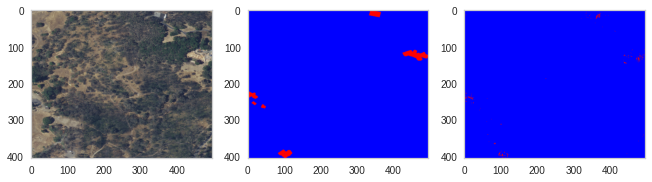

In [ ]:
folder=folder='./NAIP_img_new/'
index='00000081'
state='pre'
print('Pre fire prediction:')
pred_visual(folder,index,state,features=features)

Post fire prediction:
The accuracy and Kappa for this image are:  0.9863191244239631  and  0.05988360611910748


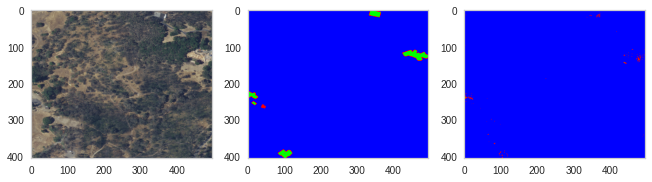

In [ ]:
folder=folder='./NAIP_img_new/'
index='00000081'
state='post'
print('Post fire prediction:')
pred_visual(folder,index,state,features=features)

Pre fire prediction:
The accuracy and Kappa for this image are:  0.9276632923596048  and  0.18122630775435633


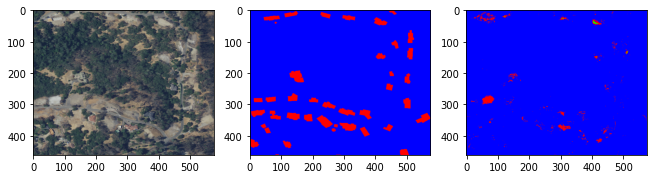

In [ ]:
folder=folder='./NAIP_img_new/'
index='00000220'
state='pre'
print('Pre fire prediction:')
pred_visual(folder,index,state,features=features)

Post fire prediction:
The accuracy and Kappa for this image are:  0.9237994094962642  and  0.12363044175970284


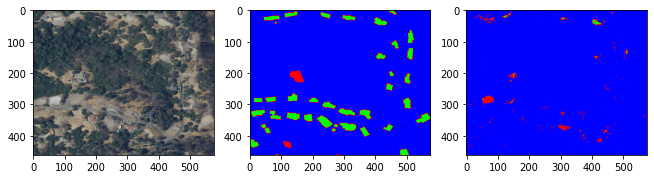

In [ ]:
folder=folder='./NAIP_img_new/'
index='00000220'
state='post'
print('Post fire prediction:')
pred_visual(folder,index,state,features=features)

Pre fire prediction:
The accuracy and Kappa for this image are:  0.9317573914566384  and  0.21089768079200133


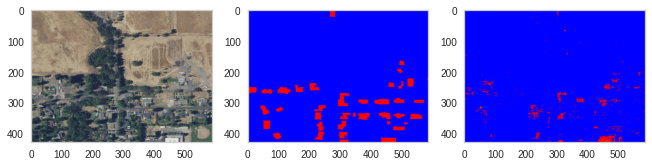

In [ ]:
folder=folder='./NAIP_img_new/'
index='00000376'
state='pre'
print('Pre fire prediction:')
pred_visual(folder,index,state,features=features)

Post fire prediction:
The accuracy and Kappa for this image are:  0.9317007431979841  and  0.18840260184778357


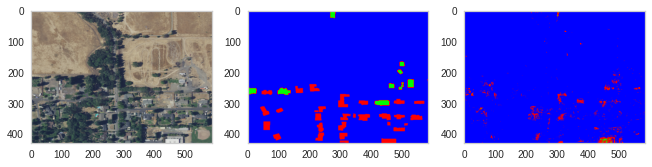

In [ ]:
folder=folder='./NAIP_img_new/'
index='00000376'
state='post'
print('Post fire prediction:')
pred_visual(folder,index,state,features=features)

The classification results visualized above showed that XGBoost is able to, at least partially, differentiate building footprints from the background. However, it is dificult to preserve the shape and exact boundary of the buildings. Moreover, it can only differentiate very little amount of destroyed buildings from no-damage buildings.

## Feature Importance

### Feature Importance

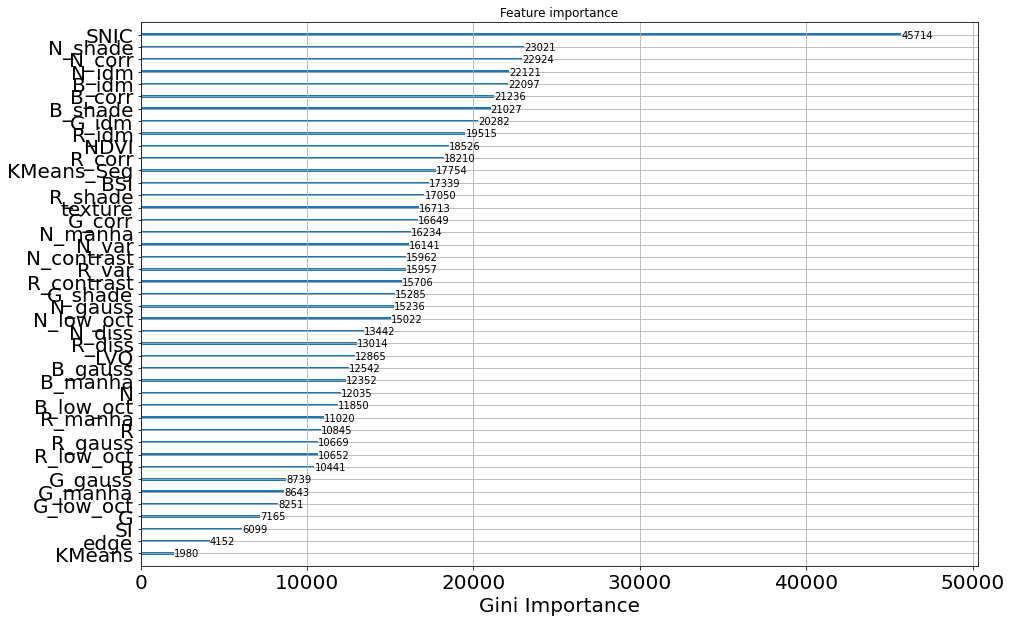

In [ ]:
fig, ax = plt.subplots()
xgb.plot_importance(gbc,ax=ax)
#fig = plt.gcf()
#fig.set_size_inches(150, 100)
ax.set_xlabel(xlabel='Gini Importance',fontsize=20)
ax.set_ylabel(ylabel='',fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
fig.set_size_inches(15, 10)

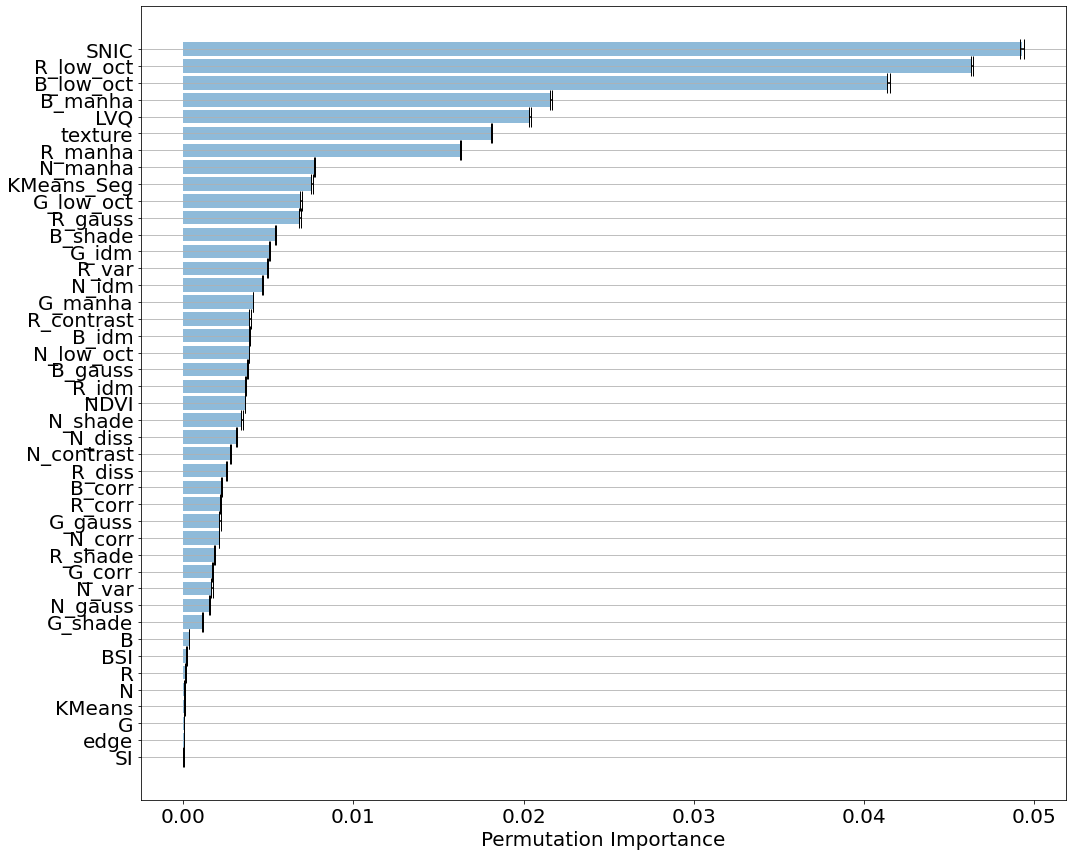

In [ ]:
col_name=np.array(train_X.columns.tolist())
imp=perm.feature_importances_
imp_std=perm.feature_importances_std_
x_pos = np.arange(len(col_name))
sort_ind=np.argsort(imp)
#sort_ind=np.argsort(imp)[::-1] #descending order
imp=imp[sort_ind]
imp_std=imp_std[sort_ind]
col_name=col_name[sort_ind]

# Build the plot
#plt.figure(figsize=(26,12))
fig, ax = plt.subplots()
ax.barh(x_pos, imp, xerr=imp_std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xlabel('Permutation Importance', fontsize=20)
ax.set_yticks(x_pos)
ax.set_yticklabels(col_name)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.yaxis.grid(True)
fig.set_size_inches(15, 12)
# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

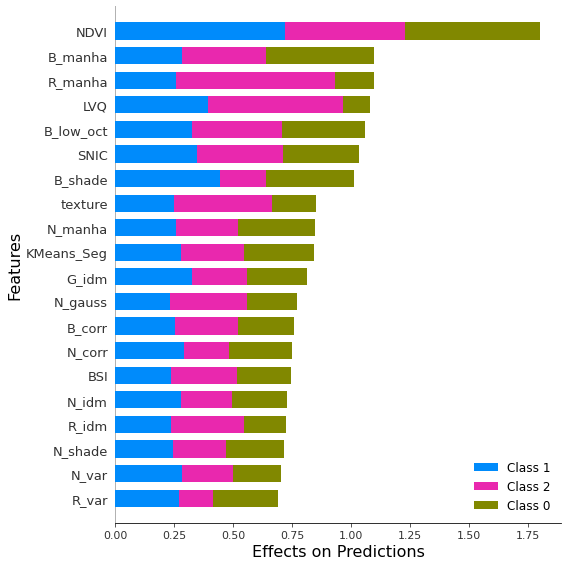

In [ ]:
ax = plt.gca()
ax.set_xlabel('Effects on Predictions', fontsize=16)
ax.set_ylabel('Features', fontsize=16)
#ax.set_xlim(-200,200)
plt.show()